# Federated Learning with BraTS 2021 Dataset
This notebook implements a federated learning framework for brain tumor segmentation using the BraTS 2021 dataset.

In [1]:
import os
import numpy as np
import nibabel as nib
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


In [2]:
images_path = 'Data/BraTS2021'
IMG_SIZE = 128  # Resize images to 128x128
VOLUME_SLICES = 50  # Number of slices per patient
VOLUME_START_AT = 22  # Start slicing from this index
REDUCE_PATIENTS = False  # Option to reduce the number of patients per hospital
PATIENT_LIMIT = 10  # Number of patients per hospital if REDUCE_PATIENTS is Tru

# Load the dataset file paths
all_patients = [os.path.join(images_path, p) for p in os.listdir(images_path)]
np.random.shuffle(all_patients)

In [3]:
# Split dataset among hospitals (nodes)
nodes = {
    "Hospital_1": all_patients[:len(all_patients)//3],
    "Hospital_2": all_patients[len(all_patients)//3:2*len(all_patients)//3],
    "Hospital_3": all_patients[2*len(all_patients)//3:]
}

In [4]:
# Define Data Generator
class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=2, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        Batch_ids = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(Batch_ids)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size * VOLUME_SLICES, 240, 240))

        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(images_path, os.path.basename(i), os.path.basename(i))
            flair = nib.load(f'{case_path}_flair.nii').get_fdata()
            ce = nib.load(f'{case_path}_t1ce.nii').get_fdata()
            seg = nib.load(f'{case_path}_seg.nii').get_fdata()

            for j in range(VOLUME_SLICES):
                X[j + VOLUME_SLICES * c, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                X[j + VOLUME_SLICES * c, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                y[j + VOLUME_SLICES * c] = seg[:, :, j + VOLUME_START_AT]

        y[y == 4] = 3  # Adjust class values
        mask = tf.one_hot(y, 4)
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

        return X / np.max(X), Y

In [5]:
# Distribute dataset into train, validation, and test sets
hospitals_data = {}
for hospital, files in nodes.items():
    np.random.shuffle(files)
    train_split = int(0.7 * len(files))
    val_split = int(0.85 * len(files))
    hospitals_data[hospital] = {
        "train": DataGenerator(files[:150]),
        "val": DataGenerator(files[150:180]),
        "test": DataGenerator(files[180:200])
    }


# Print dataset shapes for each hospital
    print(f"{hospital}: Train={len(hospitals_data[hospital]['train'])}, Val={len(hospitals_data[hospital]['val'])}, Test={len(hospitals_data[hospital]['test'])}")

Hospital_1: Train=150, Val=30, Test=20
Hospital_2: Train=150, Val=30, Test=20
Hospital_3: Train=150, Val=30, Test=20


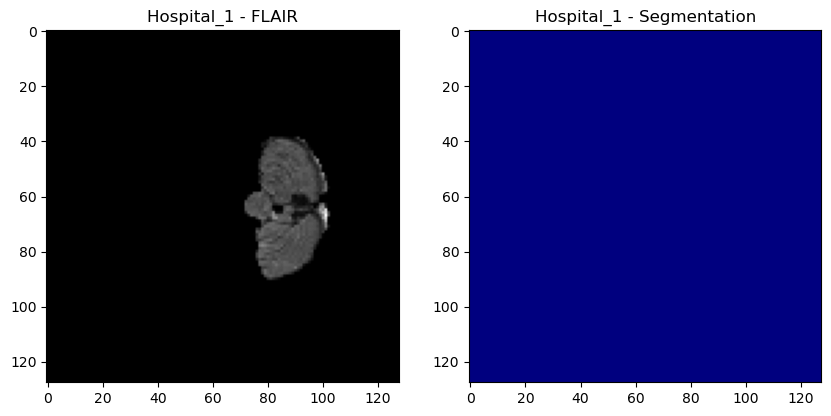

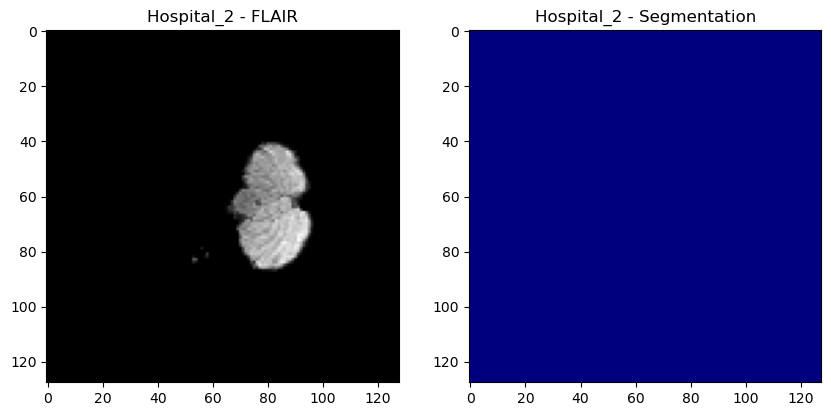

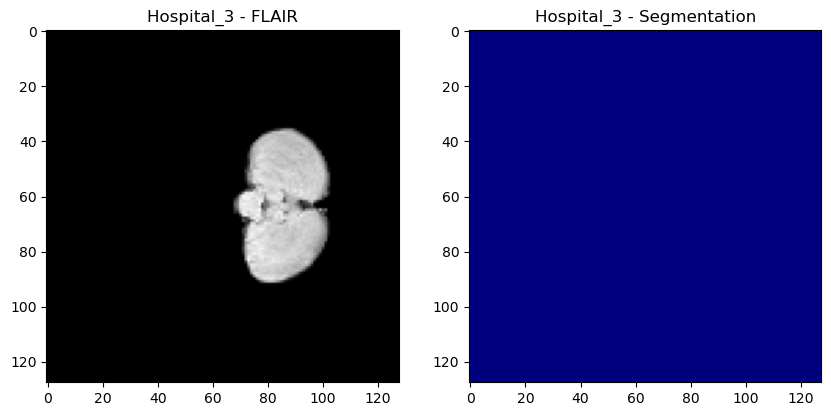

In [6]:
# Visualize Some Slices from Each Hospital
for hospital, data in hospitals_data.items():
    X_sample, y_sample = data['train'].__getitem__(0)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(X_sample[0, :, :, 0], cmap='gray')
    ax[0].set_title(f"{hospital} - FLAIR")
    ax[1].imshow(np.argmax(y_sample[0], axis=-1), cmap='jet')
    ax[1].set_title(f"{hospital} - Segmentation")
    plt.show()

In [7]:
## Cell 5: Define UNet model with proper upsampling
def create_unet_model(input_shape=(IMG_SIZE, IMG_SIZE, 2)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(4, (4, 4), strides=(4, 4), activation='softmax', padding='same')(x)  # Proper upsampling
    return keras.Model(inputs, x)

In [8]:
# Initialize models for each hospital
local_models = {}
for hospital in hospitals_data.keys():
    local_models[hospital] = create_unet_model()

In [9]:
num_rounds = 1
global_model = create_unet_model()

def federated_averaging(weight_list):
    avg_weights = []
    for weights in zip(*weight_list):
        avg_weights.append(np.mean(weights, axis=0))
    return avg_weights


In [10]:
for round_num in range(num_rounds):
    local_weights = []
    
    for hospital in hospitals_data.keys():
        print(f"Training {hospital}...")

        # Free memory before training each hospital
        tf.keras.backend.clear_session()

        # Create a fresh model to avoid memory leak
        local_model = create_unet_model()
        local_model.set_weights(global_model.get_weights())
        
        # Compile and train
        local_model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
        local_model.fit(hospitals_data[hospital]['train'], epochs=1, validation_data=hospitals_data[hospital]['val'])
        
        # Save trained weights
        local_weights.append(local_model.get_weights())

    new_global_weights = federated_averaging(local_weights)
    global_model.set_weights(new_global_weights)


Training Hospital_1...



c:\Users\binwa\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


150/150 ━━━━━━━━━━━━━━━━━━━━ 125s 811ms/step - accuracy: 0.9657 - loss: 0.5105 - val_accuracy: 0.9862 - val_loss: 0.0698
Training Hospital_2...
150/150 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.9672 - loss: 0.5205 - val_accuracy: 0.9886 - val_loss: 0.0578
Training Hospital_3...
104/150 ━━━━━━━━━━━━━━━━━━━━ 1:00 1s/step - accuracy: 0.9594 - loss: 0.6376

UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
OSError: [WinError 8] Not enough memory resources are available to process this command
Traceback (most recent call last):

  File "c:\Users\binwa\anaconda3\Lib\site-packages\tensorflow\python\ops\script_ops.py", line 270, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "c:\Users\binwa\anaconda3\Lib\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\binwa\anaconda3\Lib\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\binwa\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py", line 247, in _finite_generator
    yield self.py_dataset[i]
          ~~~~~~~~~~~~~~~^^^

  File "C:\Users\binwa\AppData\Local\Temp\ipykernel_3412\2993538711.py", line 17, in __getitem__
    X, y = self.__data_generation(Batch_ids)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\binwa\AppData\Local\Temp\ipykernel_3412\2993538711.py", line 31, in __data_generation
    flair = nib.load(f'{case_path}_flair.nii').get_fdata()
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\binwa\anaconda3\Lib\site-packages\nibabel\dataobj_images.py", line 373, in get_fdata
    data = np.asanyarray(self._dataobj, dtype=dtype)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\binwa\anaconda3\Lib\site-packages\nibabel\arrayproxy.py", line 457, in __array__
    arr = self._get_scaled(dtype=dtype, slicer=())
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\binwa\anaconda3\Lib\site-packages\nibabel\arrayproxy.py", line 424, in _get_scaled
    scaled = apply_read_scaling(self._get_unscaled(slicer=slicer), scl_slope, scl_inter)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\binwa\anaconda3\Lib\site-packages\nibabel\arrayproxy.py", line 394, in _get_unscaled
    return array_from_file(
           ^^^^^^^^^^^^^^^^

  File "c:\Users\binwa\anaconda3\Lib\site-packages\nibabel\volumeutils.py", line 450, in array_from_file
    return np.memmap(infile, in_dtype, mode=mode, shape=shape, order=order, offset=offset)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\binwa\anaconda3\Lib\site-packages\numpy\core\memmap.py", line 268, in __new__
    mm = mmap.mmap(fid.fileno(), bytes, access=acc, offset=start)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

OSError: [WinError 8] Not enough memory resources are available to process this command


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_one_step_on_iterator_13084]

In [11]:
# Ensure the global model is compiled before evaluation
global_model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

# Evaluate the global model on each hospital's test set
for hospital, data in hospitals_data.items():
    loss, acc = global_model.evaluate(data["test"])
    print(f"Global Model - {hospital}: Accuracy = {acc:.4f}, Loss = {loss:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9899 - loss: 0.0475
Global Model - Hospital_1: Accuracy = 0.9883, Loss = 0.0531
20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9907 - loss: 0.0430
Global Model - Hospital_2: Accuracy = 0.9932, Loss = 0.0333
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9872 - loss: 0.0595
Global Model - Hospital_3: Accuracy = 0.9885, Loss = 0.0561


In [12]:
# Ensure the global model is compiled before evaluation
global_model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

# Evaluate on each hospital's test set
global_results = {}
for hospital, data in hospitals_data.items():
    loss, acc = global_model.evaluate(data["test"])
    global_results[hospital] = {"Loss": loss, "Accuracy": acc}
    print(f"Global Model - {hospital}: Accuracy = {acc:.4f}, Loss = {loss:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 801ms/step - accuracy: 0.9864 - loss: 0.0606
Global Model - Hospital_1: Accuracy = 0.9883, Loss = 0.0531
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 762ms/step - accuracy: 0.9935 - loss: 0.0335
Global Model - Hospital_2: Accuracy = 0.9932, Loss = 0.0333
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 811ms/step - accuracy: 0.9892 - loss: 0.0541
Global Model - Hospital_3: Accuracy = 0.9885, Loss = 0.0561


In [13]:
# Ensure local models are compiled before evaluation
local_results = {}
for hospital, model in local_models.items():
    model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
    loss, acc = model.evaluate(hospitals_data[hospital]['test'])
    local_results[hospital] = {"Loss": loss, "Accuracy": acc}
    print(f"Local Model - {hospital}: Accuracy = {acc:.4f}, Loss = {loss:.4f}")

# Compare local vs. global accuracy
for hospital in hospitals_data.keys():
    print(f"{hospital} - Local Model Accuracy: {local_results[hospital]['Accuracy']:.4f}, Global Model Accuracy: {global_results[hospital]['Accuracy']:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 756ms/step - accuracy: 0.6961 - loss: 1.3861
Local Model - Hospital_1: Accuracy = 0.6985, Loss = 1.3861
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 761ms/step - accuracy: 0.6843 - loss: 1.3861
Local Model - Hospital_2: Accuracy = 0.6858, Loss = 1.3862
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 796ms/step - accuracy: 0.6931 - loss: 1.3863
Local Model - Hospital_3: Accuracy = 0.7002, Loss = 1.3863
Hospital_1 - Local Model Accuracy: 0.6985, Global Model Accuracy: 0.9883
Hospital_2 - Local Model Accuracy: 0.6858, Global Model Accuracy: 0.9932
Hospital_3 - Local Model Accuracy: 0.7002, Global Model Accuracy: 0.9885


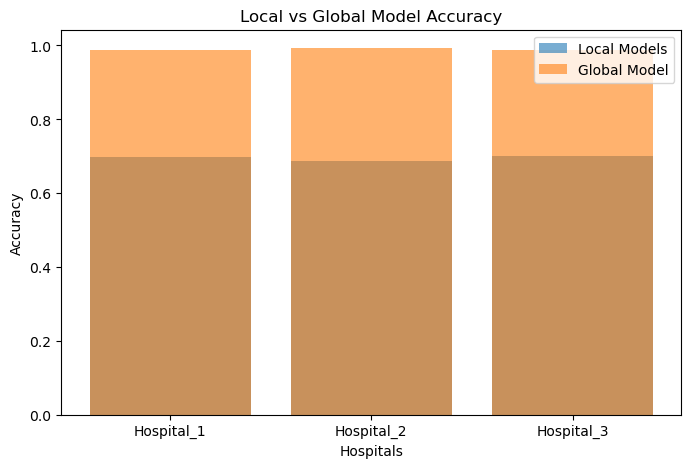

In [14]:
# Extract accuracy values
hospitals = list(hospitals_data.keys())
local_accuracies = [local_results[h]["Accuracy"] for h in hospitals]
global_accuracies = [global_results[h]["Accuracy"] for h in hospitals]

# Plot accuracy comparison
plt.figure(figsize=(8, 5))
plt.bar(hospitals, local_accuracies, alpha=0.6, label="Local Models")
plt.bar(hospitals, global_accuracies, alpha=0.6, label="Global Model")
plt.xlabel("Hospitals")
plt.ylabel("Accuracy")
plt.title("Local vs Global Model Accuracy")
plt.legend()
plt.show()


In [17]:
for hospital, data in hospitals_data.items():
    y_true_list, y_pred_list = [], []
    
    for i in range(len(data["test"])):
        X_batch, y_batch = data["test"].__getitem__(i)
        y_true_list.append(np.argmax(y_batch, axis=-1).flatten())
        y_pred_list.append(np.argmax(global_model.predict(X_batch), axis=-1).flatten())

    y_true = np.concatenate(y_true_list)
    y_pred = np.concatenate(y_pred_list)

    fpr, tpr, _ = roc_curve(y_true.ravel(), y_pred.ravel(), pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{hospital} (AUC = {roc_auc:.2f})")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


MemoryError: Unable to allocate 125. MiB for an array with shape (16383999,) and data type int64